## Introduction <a class="anchor"  id="chapter0"></a>

Early identification and detection of crop disease are essential to food security because it helps farmers prevent the spread of the disease and subsequent damage to crops. But the human eye is limited in classifying plant diseases without needing experts or lab tests which is time-consuming and expensive.
This project aims to design a computer model that will apply machine learning to detect and identify plant diseases from their leaves without needing continuous monitoring by experts and then receive peer-reviewed recommended actions based on disease labels.

## Step 1: Import Necessary Libraries <a class="anchor"  id="chapter1"></a>

In [1]:
#Import TensorFlow and other necessary libraries

from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Convolution2D,Dense,MaxPool2D,Activation,Dropout,Flatten
from keras.layers import GlobalAveragePooling2D
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.layers.normalization import BatchNormalization
import os 
import pandas as pd
import plotly.graph_objs as go
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
import glob

In [3]:
def get_files(directory):
  if not os.path.exists(directory):
    return 0
  count=0
  for current_path,dirs,files in os.walk(directory):
    for dr in dirs:
      count+= len(glob.glob(os.path.join(current_path,dr+"/*")))
  return count

## Step 2: Get Data <a class="anchor"  id="chapter2"></a>

In [4]:
#Specify directory for train and test samples

train_dir ="/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train"
test_dir="/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid"


In [5]:
#Count the labels and samples

train_samples =get_files(train_dir)
num_classes=len(glob.glob(train_dir+"/*"))
test_samples=get_files(test_dir)
print(num_classes,"Classes")
print(train_samples,"Train images")
print(test_samples,"Test images")

38 Classes
70295 Train images
17572 Test images


## Step 3: Build Input Pipeline <a class="anchor"  id="chapter3"></a>

In [6]:
#Library for building an input pipeline using Keras ImageDataGenerator

from keras.preprocessing.image import ImageDataGenerator

In [7]:
#Generate train and test inputs

train_datagen=ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
test_datagen=ImageDataGenerator(rescale=1./255)

In [8]:
img_width,img_height =224,224
input_shape=(img_width,img_height,3)
batch_size =32
train_generator =train_datagen.flow_from_directory(train_dir,target_size=(img_width,img_height),batch_size=batch_size)
test_generator=test_datagen.flow_from_directory(test_dir,shuffle=True,target_size=(img_width,img_height),batch_size=batch_size)

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


## Step 4: Compose The Model <a class="anchor"  id="chapter4"></a>

### 1. Load the pretrained base model and pretrained weights <a class="anchor"  id="subsection1"></a>
### 2. Stack the classification layers on top <a class="anchor"  id="subsection2"></a>

In [9]:
#Compose the pretrained MobileNet model

from keras.applications.mobilenet import MobileNet
from keras.models import Model
import keras
from keras import optimizers
model_finetuned = Sequential()

model_finetuned.add(MobileNet(weights='imagenet'))
model_finetuned.add(BatchNormalization())
model_finetuned.add(Dense(128, activation="relu"))
model_finetuned.add(Dense(38, activation="softmax"))
for layer in model_finetuned.layers[0].layers:
  if layer.__class__.__name__=="BatchNormalization":
    layer.trainable=True
  else:
    layer.trainable=False
model_finetuned.compile(optimizer='adam',
                  loss = 'categorical_crossentropy',
                  metrics=['accuracy'])

17227776/17225924 [==============================] - 0s 0us/step


In [10]:
#Model summary

model_finetuned.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 1000)              4253864   
_________________________________________________________________
batch_normalization (BatchNo (None, 1000)              4000      
_________________________________________________________________
dense (Dense)                (None, 128)               128128    
_________________________________________________________________
dense_1 (Dense)              (None, 38)                4902      
Total params: 4,390,894
Trainable params: 156,918
Non-trainable params: 4,233,976
_________________________________________________________________


## Step 5: Train the Model <a class="anchor"  id="chapter5"></a>

In [11]:
#Train and fit model

from keras.callbacks import ReduceLROnPlateau
validation_generator = train_datagen.flow_from_directory(
                       test_dir, # same directory as training data
                       target_size=(img_height, img_width),
                       batch_size=batch_size)

history_1 = model_finetuned.fit(train_generator,                                    
                                  steps_per_epoch=None, 
                                  epochs=8,validation_data=validation_generator,validation_steps=None
                                  ,verbose=1,callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.3,patience=3, min_lr=0.000001)],use_multiprocessing=False,
               shuffle=True)

Found 17572 images belonging to 38 classes.
Epoch 1/8
2197/2197 [==============================] - 1366s 619ms/step - loss: 1.3869 - accuracy: 0.6349 - val_loss: 0.4650 - val_accuracy: 0.8605
Epoch 2/8
2197/2197 [==============================] - 1021s 465ms/step - loss: 0.3122 - accuracy: 0.8982 - val_loss: 0.2601 - val_accuracy: 0.9193
Epoch 3/8
2197/2197 [==============================] - 1021s 465ms/step - loss: 0.2001 - accuracy: 0.9349 - val_loss: 0.1696 - val_accuracy: 0.9486
Epoch 4/8
2197/2197 [==============================] - 1022s 465ms/step - loss: 0.1348 - accuracy: 0.9546 - val_loss: 0.1379 - val_accuracy: 0.9553
Epoch 5/8
2197/2197 [==============================] - 1020s 464ms/step - loss: 0.1080 - accuracy: 0.9636 - val_loss: 0.0958 - val_accuracy: 0.9700
Epoch 6/8
2197/2197 [==============================] - 1028s 468ms/step - loss: 0.0838 - accuracy: 0.9719 - val_loss: 0.0797 - val_accuracy: 0.9740
Epoch 7/8
2197/2197 [==============================] - 1075s 490ms/s

In [12]:
#Save the model

from keras.models import load_model
model_finetuned.save('plantdiseasemobilenet8epoch.h5')

## Step 6: Evaluate the Model <a class="anchor"  id="chapter6"></a>

[[1.77955783e-08 5.07853892e-15 9.89770939e-12 1.13573500e-11
  1.53928584e-12 4.70646308e-13 4.02297372e-16 5.75259295e-13
  1.46269512e-14 3.89179059e-13 2.33205111e-13 1.52735219e-14
  7.37842242e-13 1.02756258e-12 4.08025745e-13 1.19299483e-11
  1.15807031e-09 3.65201223e-13 3.08630443e-12 6.47954116e-14
  3.05771437e-06 1.01804312e-11 4.04367403e-13 1.21243027e-09
  6.85301815e-11 5.77519640e-13 4.60841920e-10 3.15383032e-11
  9.11088219e-11 1.39438661e-09 1.00983985e-10 2.17272099e-12
  2.60775880e-11 7.07902378e-13 3.08671394e-10 9.99996901e-01
  4.74363170e-12 5.71823838e-11]]


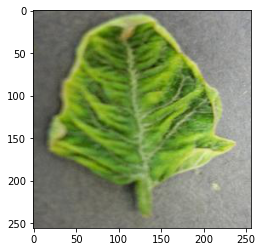

In [13]:
classes=list(train_generator.class_indices.keys())
import numpy as np
import matplotlib.pyplot as plt

# Pre-Processing test data same as train data.
img_width=224
img_height=224
model_finetuned.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
from keras.preprocessing import image
def prepare(img_path):
    img = image.load_img(img_path, target_size=(224,224))
    x = image.img_to_array(img)
    x = x/255
    return np.expand_dims(x, axis=0)
    
    
result = model_finetuned.predict([prepare('/kaggle/input/new-plant-diseases-dataset/test/test/TomatoYellowCurlVirus6.JPG')])

disease=image.load_img('/kaggle/input/new-plant-diseases-dataset/test/test/TomatoYellowCurlVirus6.JPG')
plt.imshow(disease)
print(result)

In [14]:
import numpy as np
classresult=np.argmax(result,axis=1)
print(classes[classresult[0]])

Tomato___Tomato_Yellow_Leaf_Curl_Virus


## Step 7: Convert Model to TensorFlow Lite <a class="anchor"  id="chapter7"></a>

In [15]:
import tensorflow as tf
keras_model = tf.keras.models.load_model("plantdiseasemobilenet8epoch.h5")
converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)

In [16]:
model = converter.convert()
file = open( 'outputmobilenetof8epoch.tflite' , 'wb' ) 
file.write( model )

17448648

In [17]:
import numpy as np
import tensorflow as tf

# Load the TensorFlowLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="outputmobilenetof8epoch.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print(input_details)
print("")
print(output_details)

[{'name': 'mobilenet_1.00_224_input', 'index': 0, 'shape': array([  1, 224, 224,   3], dtype=int32), 'shape_signature': array([ -1, 224, 224,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]

[{'name': 'Identity', 'index': 116, 'shape': array([ 1, 38], dtype=int32), 'shape_signature': array([-1, 38], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [18]:
def prepare(img_path):
    img = image.load_img(img_path, target_size=(224,224))
    x = image.img_to_array(img)
    x = x/255
    return np.expand_dims(x, axis=0)
    
    
input_data = [prepare('/kaggle/input/new-plant-diseases-dataset/test/test/TomatoYellowCurlVirus6.JPG')]

In [19]:
input_shape = input_details[0]['shape']
interpreter.set_tensor(input_details[0]['index'], input_data[0])

interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)

[[1.77958501e-08 5.07859737e-15 9.89793750e-12 1.13574809e-11
  1.53930937e-12 4.70651675e-13 4.02298907e-16 5.75264825e-13
  1.46270630e-14 3.89187218e-13 2.33208201e-13 1.52737252e-14
  7.37854873e-13 1.02757245e-12 4.08032007e-13 1.19299483e-11
  1.15807264e-09 3.65205424e-13 3.08633414e-12 6.47961502e-14
  3.05781055e-06 1.01806064e-11 4.04372038e-13 1.21244415e-09
  6.85305701e-11 5.77531783e-13 4.60848082e-10 3.15388445e-11
  9.11098766e-11 1.39441581e-09 1.00985144e-10 2.17270451e-12
  2.60778881e-11 7.07910456e-13 3.08675530e-10 9.99996901e-01
  4.74363214e-12 5.71831506e-11]]


In [20]:
classresult=np.argmax(output_data,axis=1)
print(classes[classresult[0]])

Tomato___Tomato_Yellow_Leaf_Curl_Virus


## Step 8: Evaluate Performance <a class="anchor"  id="chapter8"></a>

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


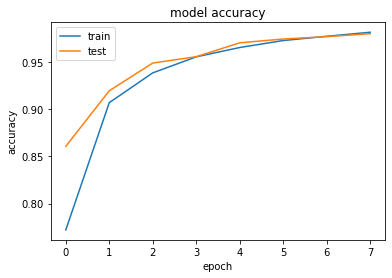

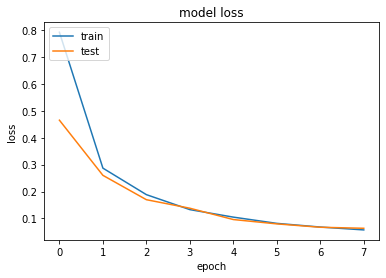

In [21]:
# import necessary libraries

from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
import numpy

print(history_1.history.keys())

# summarize history for accuracy
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()